In [299]:
import numpy as np
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, Trainset, AlgoBase, accuracy
from tqdm import tqdm
from surprise import AlgoBase, Trainset
from surprise.model_selection import GridSearchCV
from sklearn.utils import resample
from collections import defaultdict
from math import log2
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import mean_absolute_error


tqdm.pandas()

In [300]:
books = pd.read_pickle('../Pickle/books.pkl')

In [301]:
interactions = pd.read_pickle('../Pickle/interactions.pkl')

In [302]:
interactions = interactions[['user_id', 'book_id', 'rating', 'is_read']]  

In [303]:
# Filter user IDs that appear more than 5 times
user_counts = interactions['user_id'].value_counts()
interactions = interactions[interactions['user_id'].isin(user_counts[user_counts >= 5].index)]

# Filter book IDs that appear more than 5 times
book_counts = interactions['book_id'].value_counts()
interactions = interactions[interactions['book_id'].isin(book_counts[book_counts >= 5].index)]

In [304]:
# First, split the users into train and test
users = interactions['user_id'].unique()
train_users, test_users = train_test_split(users, test_size=0.2, random_state=42)

# Create the train and test sets based on the users
train_df = interactions[interactions['user_id'].isin(train_users)]
test_df = interactions[interactions['user_id'].isin(test_users)]

# Make sure there is no overlap in user-item pairs between train and test sets
train_items = train_df[['user_id', 'book_id']].drop_duplicates()
test_items = test_df[['user_id', 'book_id']].drop_duplicates()

# Remove any overlapping user-item pairs between the train and test sets
test_df = test_df[~test_df[['user_id', 'book_id']].isin(train_items).all(axis=1)]


In [305]:
from sklearn.utils import resample

# Get rating counts
rating_counts = train_df['rating'].value_counts()

# Find the majority class size (highest count)
majority_count = rating_counts.max()

# Dictionary to store oversampled dataframes
oversampled_dfs = []

# Perform upsampling for each class to match a proportion of the majority count
for rating, count in rating_counts.items():
    class_df = train_df[train_df['rating'] == rating]
    
    # Upsample based on a percentage of the majority class size
    if count < majority_count:
        upsampled_df = resample(class_df, replace=True, n_samples=int(majority_count * 0.6), random_state=42)  # 75% of the majority class
    else:
        upsampled_df = class_df  # Keep majority class as is
    
    oversampled_dfs.append(upsampled_df)

# Combine all upsampled data
balanced_train = pd.concat(oversampled_dfs)

# Shuffle dataset
train_df = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)


In [306]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ensure that the DataFrame you're working with is a proper copy (not a slice)
train_df = train_df.copy()  # Create a copy if it's a slice
test_df = test_df.copy()  # Do the same for the test DataFrame

# Now, apply normalization
train_df['normalised_rating'] = scaler.fit_transform(train_df[['rating']])
test_df['normalised_rating'] = scaler.fit_transform(test_df[['rating']])


In [307]:
from custom_svd import RandomizedSVD
from surprise import Dataset, Reader

# Prepare the Reader object to specify the rating scale
reader = Reader(rating_scale=(train_df['normalised_rating'].min(), train_df['normalised_rating'].max()))

# Convert your train and test DataFrames to Surprise format
train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'normalised_rating']], reader)
test_data = Dataset.load_from_df(test_df[['user_id', 'book_id', 'normalised_rating']], reader)


# Initialize the custom RandomizedSVD model
model = RandomizedSVD(n_factors=500, n_iter=60, random_state=42)

# Fit the model to the training data
trainset = train_data.build_full_trainset()  # Build a full training set from the Surprise dataset
model.fit(trainset)

# Convert the test DataFrame to a list of (user_id, book_id) pairs for prediction
testset = test_data.build_full_trainset().build_testset()  # Build a test set from the Surprise dataset

# Make predictions on the test set
predictions = model.test(testset)


In [308]:
# Extract the predicted ratings and reverse the normalization
predicted_ratings = [pred.est for pred in predictions]

# Convert to a numpy array for easier handling
predicted_ratings_array = np.array(predicted_ratings).reshape(-1, 1)

# Reverse the normalization using inverse_transform
original_predicted_ratings = scaler.inverse_transform(predicted_ratings_array)

# Convert back to a list or use as needed
original_predicted_ratings = original_predicted_ratings.flatten()


In [309]:
original_predicted_ratings

array([2.65000143, 2.65000143, 2.65000143, ..., 2.65000143, 2.65000143,
       2.65000143])

In [310]:
from surprise import accuracy

# Calculate MAE and RMSE
mae = accuracy.mae(predictions)
rmse = accuracy.rmse(predictions)

MAE:  0.2938
RMSE: 0.3330


In [311]:
def precision_recall_ndcg_at_k(predictions, k, threshold):
    """Return precision, recall, and nDCG at k metrics for each user."""
    
    # Helper function to calculate DCG and nDCG
    def dcg_at_k(scores, k):
        return sum([rel / log2(idx + 2) for idx, rel in enumerate(scores[:k])])

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    ndcgs = dict()
    
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        
        # nDCG@K
        actual = [true_r for (_, true_r) in user_ratings]
        ideal = sorted(actual, reverse=True)
        
        idcg = dcg_at_k(ideal, k)
        dcg = dcg_at_k([rel for (est, rel) in user_ratings], k)
        
        ndcgs[uid] = dcg / idcg if idcg > 0 else 0
    
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    ndcg = sum(ndcg for ndcg in ndcgs.values()) / len(ndcgs)
    
    return precision, recall, ndcg

In [312]:
precision, recall, ndcg = precision_recall_ndcg_at_k(predictions, k=10, threshold=3.5)
print(f'Adjusted Precision: {precision}, Adjusted Recall: {recall}, Adjusted nDCG: {ndcg}')

Adjusted Precision: 1.0, Adjusted Recall: 1.0, Adjusted nDCG: 0.6770851768088435


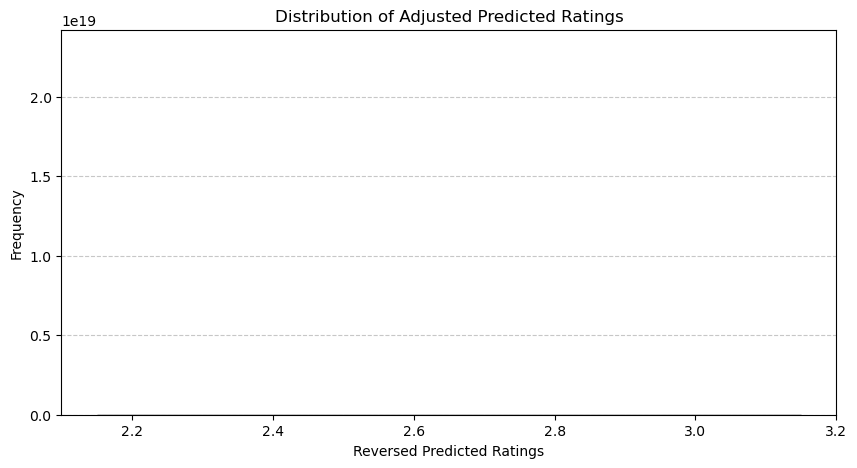

In [313]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(original_predicted_ratings, bins=20, kde=True, color='blue')

plt.xlabel('Reversed Predicted Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Adjusted Predicted Ratings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [314]:
import numpy as np

true_ratings = np.array([pred.r_ui for pred in predictions])
predicted_ratings = np.array([pred.est for pred in predictions])

print("Mean True Rating:", true_ratings.mean())
print("Mean Predicted Rating:", predicted_ratings.mean())


Mean True Rating: 0.7532738302768288
Mean Predicted Rating: 0.5300002868736194


In [315]:
global_mean = model.trainset.global_mean
print(f"Global mean: {global_mean}")


Global mean: 0.5300002868736194


In [316]:
predicted_ratings = [pred.est for pred in predictions]
print(predicted_ratings[:10])  # Check first 10 predictions


[0.5300002868736194, 0.5300002868736194, 0.5300002868736194, 0.5300002868736194, 0.5300002868736194, 0.5300002868736194, 0.5300002868736194, 0.5300002868736194, 0.5300002868736194, 0.5300002868736194]


In [317]:
print(f"User factors shape: {model.user_factors.shape}")
print(f"Item factors shape: {model.item_factors.shape}")
print(f"Sample of user factors: {model.user_factors[:5, :]}")
print(f"Sample of item factors: {model.item_factors[:5, :]}")


User factors shape: (1566, 500)
Item factors shape: (16009, 500)
Sample of user factors: [[ 2.96867912e+00  2.92334050e+00 -1.71026103e+00 ...  3.05205897e-01
   3.13425985e-01  1.19203668e-01]
 [ 2.74296253e+00 -6.67389897e-01  9.08933422e-01 ...  1.14539190e-01
   4.40125352e-02 -5.02846522e-01]
 [ 2.86427249e+00 -1.23565915e+00  3.79258951e-01 ...  2.89791113e-03
   4.66187786e-02 -1.01113990e-01]
 [ 2.34135448e+00 -7.88548163e-01 -3.17350908e-01 ... -2.73216257e-01
   5.48823861e-01  2.67499076e-01]
 [ 4.41577219e+00 -1.42545512e+00 -2.72968301e-01 ...  1.04961602e-02
  -1.18112715e-02  9.19459643e-02]]
Sample of item factors: [[ 1.01180693e-03  1.94370429e-03 -3.49541859e-03 ...  2.74256260e-03
   5.06007095e-03 -2.22634464e-03]
 [ 2.48377040e-04  1.46580731e-05 -2.80334741e-04 ... -6.54568481e-04
  -9.26600277e-04  1.68998757e-03]
 [ 1.16134522e-02 -9.24197624e-03  1.30284748e-03 ... -1.51736557e-02
  -2.49844072e-02  2.79814700e-02]
 [ 8.86003826e-03 -6.13724273e-03  5.76158611e

In [318]:
# Check the sparsity of the user-item interaction matrix
interaction_matrix = np.zeros((trainset.n_users, trainset.n_items))
for user_id, iid, rating in trainset.all_ratings():
    interaction_matrix[int(user_id), int(iid)] = rating

sparsity = 1.0 - (np.count_nonzero(interaction_matrix) / float(interaction_matrix.size))
print(f"Sparsity of the training set: {sparsity * 100:.2f}%")


Sparsity of the training set: 99.37%
